In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, regularizers
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
y_train_full = y_train_full.flatten()
y_test = y_test.flatten()

print(f'Full training set size: {len(x_train_full)}')
print(f'Test set size: {len(x_test)}')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Full training set size: 50000
Test set size: 10000


In [ ]:
# Convert pixel values to float32 and normalize to [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Calculate mean and standard deviation for normalization
mean = np.mean(x_train_full, axis=(0, 1, 2))
std = np.std(x_train_full, axis=(0, 1, 2))

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Calculated mean: [0.4914009  0.48215896 0.4465308 ]
Calculated std: [0.24703279 0.24348423 0.26158753]


In [ ]:
train_size = int(0.8 * len(x_train_full))
val_size = len(x_train_full) - train_size

# Split the dataset
x_train, x_val = x_train_full[:train_size], x_train_full[train_size:]
y_train, y_val = y_train_full[:train_size], y_train_full[train_size:]

print(f'Training set size: {len(x_train)}')
print(f'Validation set size: {len(x_val)}')
print(f'Test set size: {len(x_test)}')

Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [ ]:
# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

In [ ]:
def normalize_image(img):
    img = (img - mean) / std
    return img
def random_crop(img, crop_size):
    height, width = img.shape[0], img.shape[1]
    dy, dx = crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]
def pad_and_random_crop(img, crop_size=(32, 32), padding=4):
    img = np.pad(img, ((padding, padding),
                 (padding, padding), (0, 0)), mode='reflect')
    img = random_crop(img, crop_size)
    return img
def preprocess_train_image(img):
    img = pad_and_random_crop(img)
    img = normalize_image(img)
    return img

In [ ]:
# Training data generator with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_train_image,
    horizontal_flip=True
)
# Validation and test data generator without augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=normalize_image
)

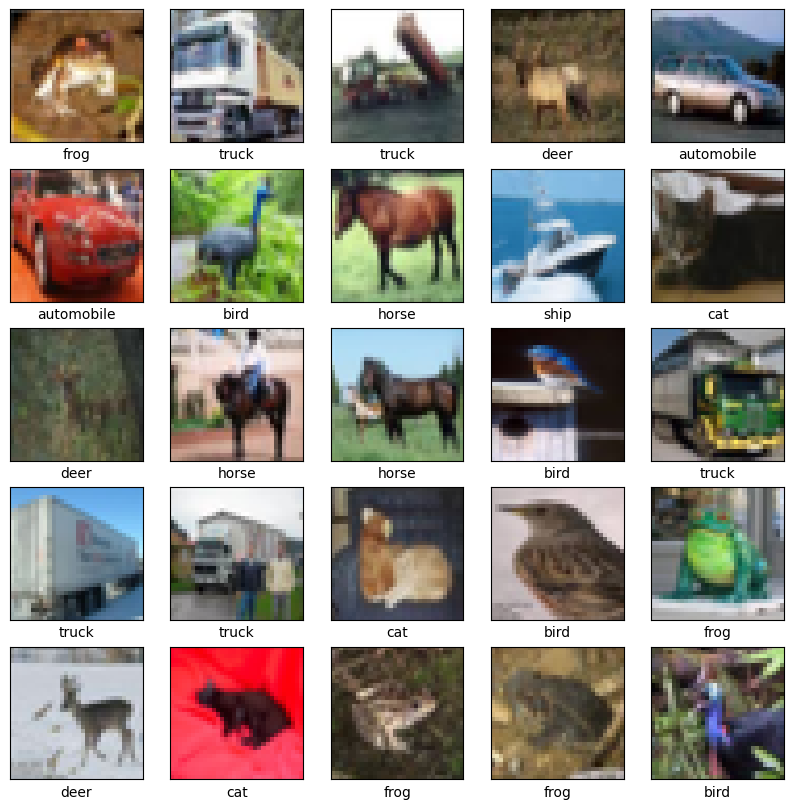

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(25):
    image = x_train[i]
    label = y_train[i]
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(class_names[label])
plt.show()

### CNN Models Initialization

explain residual-like skip connection
https://chautuankien.medium.com/skip-connection-and-explanation-of-resnet-afabe792346c

In [ ]:
def initialize_baseline():
    model = models.Sequential()

    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(10, activation='softmax'))

    return model


print(initialize_baseline().summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,253,834 (12.41 MB)

 Trainable params: 3,251,018 (12.40 MB)

 Non-trainable params: 2,816 (11.00 KB)

None


In [ ]:
def initialize_resnet50():
    base_model = ResNet50(
        include_top=False,
        weights=None,
        input_shape=(32, 32, 3),
        pooling='avg'
    )
    x = base_model.output
    x = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=x)
    return model


print(initialize_resnet50().summary())

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [ ]:
def initialize_mobilenetv2():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(32, 32, 3),
        alpha=1.0,
        include_top=False,
        weights=None,
        pooling='avg'
    )
    x = base_model.output
    x = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=x)
    return model

print(initialize_mobilenetv2().summary())

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


In [ ]:
def initialize_alexnet():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), strides=(
        1, 1), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(192, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


print(initialize_alexnet().summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 192)         │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 384)           │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │          40,9

 Total params: 35,859,786 (136.79 MB)

 Trainable params: 35,857,482 (136.79 MB)

 Non-trainable params: 2,304 (9.00 KB)

None


## Learning Rate Scheduler

In [ ]:
batch_sizes = [64, 128]
learning_rates = [0.1, 0.01, 0.001]
optimizers_list = ['SGD', 'Adam']
num_epochs_list = [30]

In [ ]:
def train_model(model, model_name, optimizer_name, learning_rate, num_epochs, batch_size):
    if optimizer_name == 'SGD':
        optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(
        filepath=f'/content/drive/MyDrive/{model_name}_checkpoint.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=2, min_delta=1e-4, mode='min')

    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
    val_generator = test_datagen.flow(x_val, y_val, batch_size=batch_size, shuffle=False)
    test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    return model, history, test_generator

In [ ]:
baseline_cnn_results = {}
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for lr in learning_rates:
            for opt_name in optimizers_list:
                print(
                    f'Training Baseline CNN with batch size = {batch_size},learning rate = {lr}, optimizer = {opt_name}')
                model = initialize_baseline()
                model, history, test_gen = train_model(
                    model, 'baseline_cnn', opt_name, lr, num_epochs,batch_size )
                key = f'lr_{lr}_opt_{opt_name}_bs_{batch_size}_epochs_{num_epochs}'
                baseline_cnn_results[key] = {
                    'model': model,
                    'history': history,
                    'test_generator': test_gen
                }

Training Baseline CNN with batch size = 64,learning rate = 0.1, optimizer = SGD
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2303 - loss: 5.8459
Epoch 1: val_loss improved from inf to 2.15467, saving model to /content/drive/MyDrive/baseline_cnn_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.2310 - loss: 5.8280 - val_accuracy: 0.4140 - val_loss: 2.1547 - learning_rate: 0.1000
Epoch 2/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3943 - loss: 2.0458
Epoch 2: val_loss improved from 2.15467 to 1.59670, saving model to /content/drive/MyDrive/baseline_cnn_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3944 - loss: 2.0449 - val_accuracy: 0.4993 - val_loss: 1.5967 - learning_rate: 0.1000
Epoch 3/30
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4734 - loss: 1.6795
Epoch 3: val_loss improved from 1.59670 to 1.54558, saving model to /content/drive/MyDrive/baseline_cnn_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4737 - loss: 1.6791 - val_accuracy:

In [ ]:
for key, result in baseline_cnn_results.items():
    print(f"{key}: Final Validation Accuracy = {result['history'].history['val_accuracy'][-1]:.4f}")

lr_0.1_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.8650
lr_0.1_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.2958
lr_0.01_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.8829
lr_0.01_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.8746
lr_0.001_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.8311
lr_0.001_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.8916
lr_0.1_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.8525
lr_0.1_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.4718
lr_0.01_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.8735
lr_0.01_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.8788
lr_0.001_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.7806
lr_0.001_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.8845


In [ ]:
resnet_results = {}
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for lr in learning_rates:
            for opt_name in optimizers_list:
                print(
                    f'Training ResNet-50 with batch size = {batch_size},learning rate = {lr}, optimizer = {opt_name}')
                model = initialize_resnet50()
                model, history, test_gen = train_model(
                    model, 'resnet',opt_name, lr, num_epochs, batch_size)
                key = f'lr_{lr}_opt_{opt_name}_bs_{batch_size}_epochs_{num_epochs}'
                resnet_results[key] = {
                    'model': model,
                    'history': history,
                    'test_generator': test_gen
                }

Training ResNet-50 with batch size = 64,learning rate = 0.1, optimizer = SGD
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1128 - loss: 8.2206
Epoch 1: val_loss improved from inf to 2.32954, saving model to /content/drive/MyDrive/resnet_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - accuracy: 0.1128 - loss: 8.2139 - val_accuracy: 0.1474 - val_loss: 2.3295 - learning_rate: 0.1000
Epoch 2/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1528 - loss: 2.2255
Epoch 2: val_loss did not improve from 2.32954
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1529 - loss: 2.2253 - val_accuracy: 0.1523 - val_loss: 2.3335 - learning_rate: 0.1000
Epoch 3/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2089 - loss: 2.0603
Epoch 3: val_loss improved from 2.32954 to 2.03232, saving model to /content/drive/MyDrive/resnet_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.2089 - loss: 2.0602 - val_accuracy: 

In [ ]:
for key, result in resnet_results.items():
    print(f"{key}: Final Validation Accuracy = {result['history'].history['val_accuracy'][-1]:.4f}")

lr_0.1_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.5570
lr_0.1_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.0992
lr_0.01_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.3928
lr_0.01_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.7898
lr_0.001_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.6243
lr_0.001_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.6885
lr_0.1_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.6020
lr_0.1_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.6251
lr_0.01_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.5956
lr_0.01_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.7957
lr_0.001_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.6262
lr_0.001_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.7034


In [ ]:
alexnet_results = {}
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for lr in learning_rates:
            for opt_name in optimizers_list:
                print(
                    f'Training AlexNet with batch size = {batch_size},learning rate = {lr}, optimizer = {opt_name}')
                model = initialize_alexnet()
                model, history, test_gen = train_model(
                    model, 'alexnet',opt_name, lr, num_epochs, batch_size)
                key = f'lr_{lr}_opt_{opt_name}_bs_{batch_size}_epochs_{num_epochs}'
                alexnet_results[key] = {
                    'model': model,
                    'history': history,
                    'test_generator': test_gen
                }

Training AlexNet with batch size = 64,learning rate = 0.1, optimizer = SGD
Epoch 1/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1113 - loss: 3.9767
Epoch 1: val_loss improved from inf to 2.30801, saving model to /content/drive/MyDrive/alexnet_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.1113 - loss: 3.9684 - val_accuracy: 0.1025 - val_loss: 2.3080 - learning_rate: 0.1000
Epoch 2/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1004 - loss: 2.3085
Epoch 2: val_loss improved from 2.30801 to 2.30498, saving model to /content/drive/MyDrive/alexnet_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1004 - loss: 2.3085 - val_accuracy: 0.0980 - val_loss: 2.3050 - learning_rate: 0.1000
Epoch 3/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1030 - loss: 2.3052
Epoch 3: val_loss improved from 2.30498 to 2.30498, saving model to /content/drive/MyDrive/alexnet_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━

In [ ]:
for key, result in alexnet_results.items():
    print(f"{key}: Final Validation Accuracy = {result['history'].history['val_accuracy'][-1]:.4f}")

lr_0.1_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.0980
lr_0.1_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.0977
lr_0.01_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.8688
lr_0.01_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.0952
lr_0.001_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.8438
lr_0.001_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.8928
lr_0.1_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.7919
lr_0.1_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.0952
lr_0.01_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.8599
lr_0.01_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.0952
lr_0.001_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.8293
lr_0.001_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.8410


In [ ]:
mobilenetv2_results = {}
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for lr in learning_rates:
            for opt_name in optimizers_list:
                print(
                    f'Training MobileNetV2 with batch size = {batch_size},learning rate = {lr}, optimizer = {opt_name}')
                model = initialize_mobilenetv2()
                model, history, test_gen = train_model(
                    model, 'mobilenet',opt_name, lr, num_epochs, batch_size)
                key = f'lr_{lr}_opt_{opt_name}_bs_{batch_size}_epochs_{num_epochs}'
                mobilenetv2_results[key] = {
                    'model': model,
                    'history': history,
                    'test_generator': test_gen
                }

Training MobileNetV2 with batch size = 64,learning rate = 0.1, optimizer = SGD
Epoch 1/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1336 - loss: 3.2896
Epoch 1: val_loss improved from inf to 2.37536, saving model to /content/drive/MyDrive/mobilenet_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.1337 - loss: 3.2871 - val_accuracy: 0.0977 - val_loss: 2.3754 - learning_rate: 0.1000
Epoch 2/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2305 - loss: 2.0227
Epoch 2: val_loss did not improve from 2.37536
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2305 - loss: 2.0225 - val_accuracy: 0.1239 - val_loss: 3.1325 - learning_rate: 0.1000
Epoch 3/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2812 - loss: 1.9044
Epoch 3: val_loss did not improve from 2.37536
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2812 - loss: 1.9043 - val_accuracy: 0.1226 - val_loss: 2.6999 - learning_rate: 0.1000
Epoch 4/30
624/625 ━

In [ ]:
for key, result in mobilenetv2_results.items():
    print(f"{key}: Final Validation Accuracy = {result['history'].history['val_accuracy'][-1]:.4f}")

lr_0.1_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.5885
lr_0.1_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.1023
lr_0.01_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.5785
lr_0.01_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.7707
lr_0.001_opt_SGD_bs_64_epochs_30: Final Validation Accuracy = 0.5865
lr_0.001_opt_Adam_bs_64_epochs_30: Final Validation Accuracy = 0.7079
lr_0.1_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.5759
lr_0.1_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.6405
lr_0.01_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.1246
lr_0.01_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.7151
lr_0.001_opt_SGD_bs_128_epochs_30: Final Validation Accuracy = 0.1016
lr_0.001_opt_Adam_bs_128_epochs_30: Final Validation Accuracy = 0.1016


In [ ]:
def find_best_model(results_dict):
    best_acc = 0.0
    best_key = None
    for key in results_dict:
        history = results_dict[key]['history']
        val_acc = history.history['val_accuracy'][-1]
        if val_acc > best_acc:
            best_acc = val_acc
            best_key = key
    return best_key, best_acc

In [ ]:
def evaluate_model(model, generator):
    loss, accuracy = model.evaluate(generator)
    return accuracy

In [ ]:
best_key_basic_cnn, best_acc_basic_cnn = find_best_model(baseline_cnn_results)
print(
    f'Best Basic CNN model: {best_key_basic_cnn}, Validation Accuracy: {best_acc_basic_cnn:.4f}')

best_model_basic_cnn = baseline_cnn_results[best_key_basic_cnn]['model']
best_test_generator = baseline_cnn_results[best_key_basic_cnn]['test_generator']
test_acc_basic_cnn = evaluate_model(best_model_basic_cnn, best_test_generator)
print(f'Test Accuracy of Best Basic CNN Model: {test_acc_basic_cnn:.4f}')

Best Basic CNN model: lr_0.001_opt_Adam_bs_64_epochs_30, Validation Accuracy: 0.8916
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8806 - loss: 0.6727
Test Accuracy of Best Basic CNN Model: 0.8826


In [ ]:
best_key_resnet, best_acc_resnet = find_best_model(resnet_results)
print(
    f'Best ResNet-50 model: {best_key_resnet}, Validation Accuracy: {best_acc_resnet:.4f}')

best_model_resnet = resnet_results[best_key_resnet]['model']
best_test_generator = resnet_results[best_key_resnet]['test_generator']
test_acc_resnet = evaluate_model(best_model_resnet, best_test_generator)
print(f'Test Accuracy of Best ResNet-50 Model: {test_acc_resnet:.4f}')

Best ResNet-50 model: lr_0.01_opt_Adam_bs_128_epochs_30, Validation Accuracy: 0.7957
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7859 - loss: 0.6759
Test Accuracy of Best ResNet-50 Model: 0.7850


In [ ]:
best_key_alexnet, best_acc_alexnet = find_best_model(alexnet_results)
print(
    f'Best AlexNet model: {best_key_alexnet}, Validation Accuracy: {best_acc_alexnet:.4f}')

best_model_alexnet = alexnet_results[best_key_alexnet]['model']
best_test_generator = alexnet_results[best_key_alexnet]['test_generator']
test_acc_alexnet = evaluate_model(best_model_alexnet, best_test_generator)
print(f'Test Accuracy of Best AlexNet Model: {test_acc_alexnet:.4f}')

Best AlexNet model: lr_0.001_opt_Adam_bs_64_epochs_30, Validation Accuracy: 0.8928
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8932 - loss: 0.3691
Test Accuracy of Best AlexNet Model: 0.8909


In [ ]:

best_key_mobilenetv2, best_acc_mobilenetv2 = find_best_model(mobilenetv2_results)
print(
    f'Best MobileNetV2 model: {best_key_mobilenetv2}, Validation Accuracy: {best_acc_mobilenetv2:.4f}')

best_model_mobilenetv2 = mobilenetv2_results[best_key_mobilenetv2]['model']
best_test_generator = mobilenetv2_results[best_key_mobilenetv2]['test_generator']
test_acc_mobilenetv2 = evaluate_model(
    best_model_mobilenetv2, best_test_generator)
print(f'Test Accuracy of Best MobileNetV2 Model: {test_acc_mobilenetv2:.4f}')

Best MobileNetV2 model: lr_0.01_opt_Adam_bs_64_epochs_30, Validation Accuracy: 0.7707
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7669 - loss: 0.6765
Test Accuracy of Best MobileNetV2 Model: 0.7662


In [ ]:

def plot_history(history, title):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'],
             'ro-', label='Validation loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training acc')
    plt.plot(epochs, history.history['val_accuracy'],
             'ro-', label='Validation acc')
    plt.title(f'Training and Validation Accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

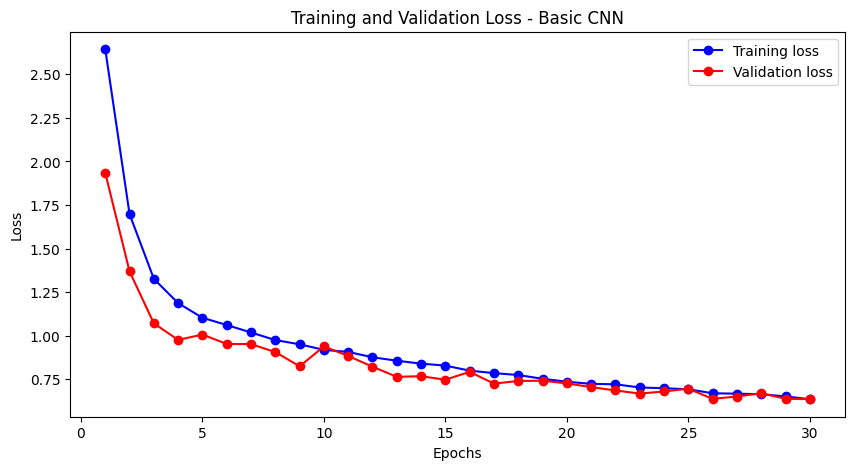

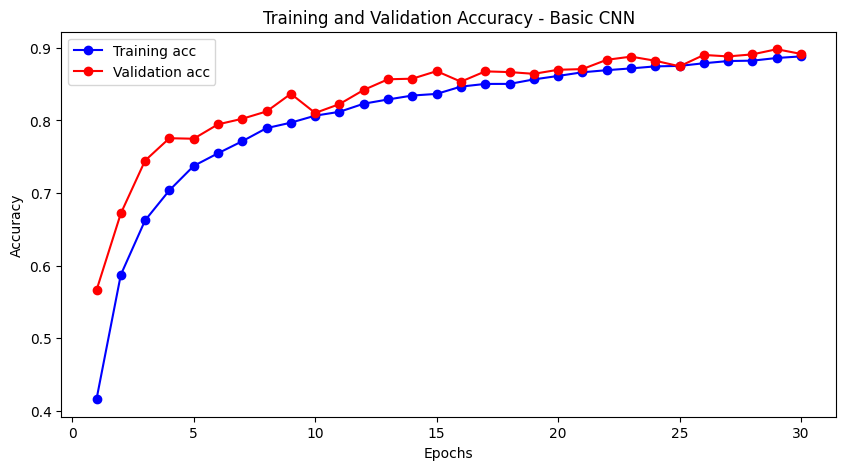

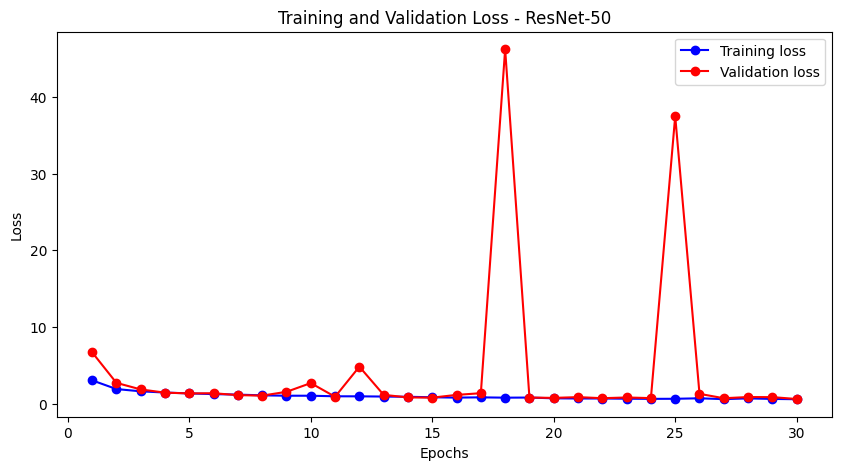

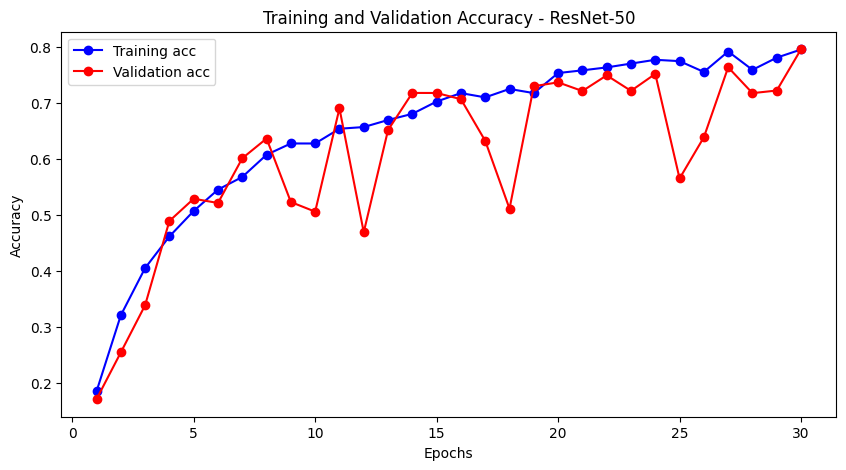

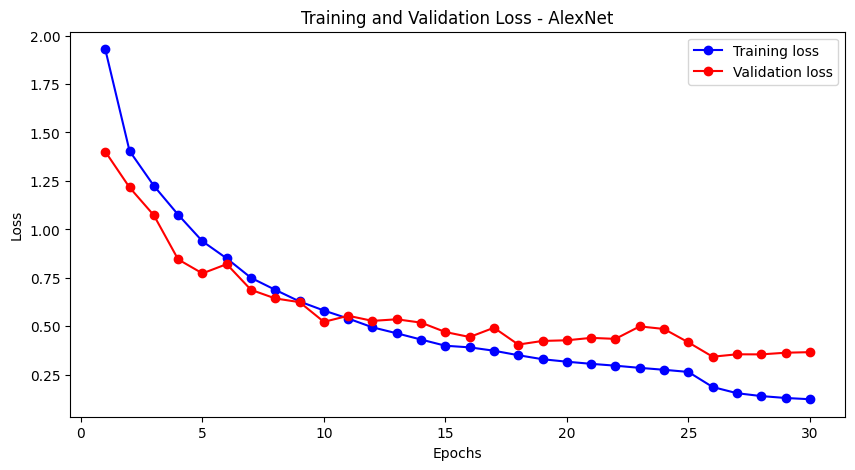

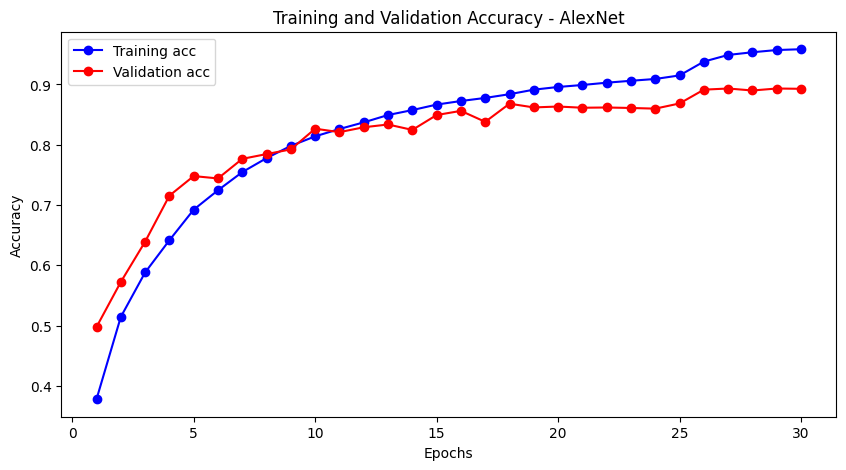

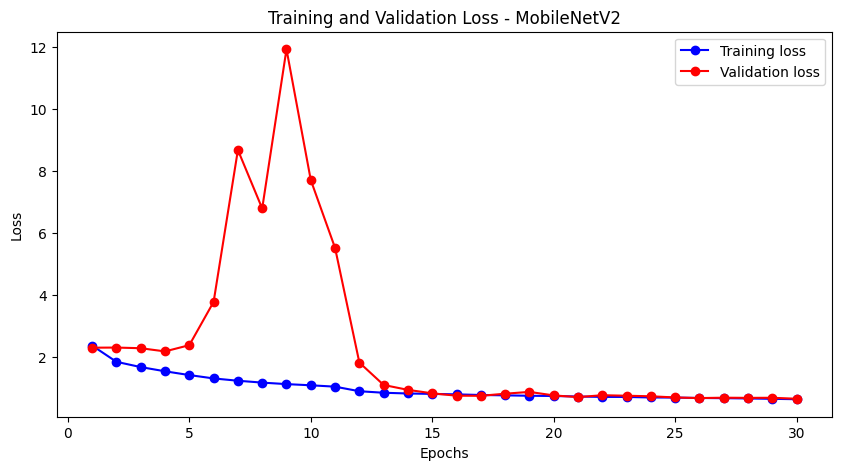

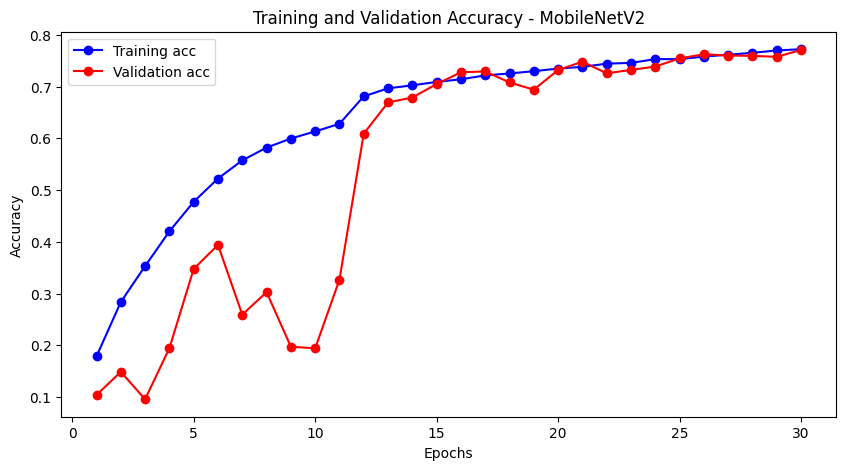

In [ ]:
plot_history(baseline_cnn_results[best_key_basic_cnn]['history'], 'Basic CNN')
plot_history(resnet_results[best_key_resnet]['history'], 'ResNet-50')
plot_history(alexnet_results[best_key_alexnet]['history'], 'AlexNet')
plot_history(
    mobilenetv2_results[best_key_mobilenetv2]['history'], 'MobileNetV2')

In [ ]:
best_key_basic_cnn, best_acc_basic_cnn = find_best_model(baseline_cnn_results)
best_key_resnet, best_acc_resnet = find_best_model(resnet_results)
best_key_alexnet, best_acc_alexnet = find_best_model(alexnet_results)
best_key_mobilenetv2, best_acc_mobilenetv2 = find_best_model(mobilenetv2_results)

In [ ]:
test_acc_basic_cnn = evaluate_model(baseline_cnn_results[best_key_basic_cnn]['model'], baseline_cnn_results[best_key_basic_cnn]['test_generator'])
test_acc_resnet = evaluate_model(resnet_results[best_key_resnet]['model'], resnet_results[best_key_resnet]['test_generator'])
test_acc_alexnet = evaluate_model(alexnet_results[best_key_alexnet]['model'], alexnet_results[best_key_alexnet]['test_generator'])
test_acc_mobilenetv2 = evaluate_model(mobilenetv2_results[best_key_mobilenetv2]['model'], mobilenetv2_results[best_key_mobilenetv2]['test_generator'])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8806 - loss: 0.6727
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7859 - loss: 0.6759
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8932 - loss: 0.3691
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7669 - loss: 0.6765


In [ ]:
results_summary = {
    'Model': ['Basic CNN', 'ResNet-50', 'AlexNet', 'MobileNetV2'],
    'Best Hyperparameters': [best_key_basic_cnn, best_key_resnet, best_key_alexnet, best_key_mobilenetv2],
    'Validation Accuracy': [best_acc_basic_cnn, best_acc_resnet, best_acc_alexnet, best_acc_mobilenetv2],
    'Test Accuracy': [test_acc_basic_cnn, test_acc_resnet, test_acc_alexnet, test_acc_mobilenetv2]
}

df_results = pd.DataFrame(results_summary)
print(df_results)

         Model               Best Hyperparameters  Validation Accuracy  \
0    Basic CNN  lr_0.001_opt_Adam_bs_64_epochs_30               0.8916   
1    ResNet-50  lr_0.01_opt_Adam_bs_128_epochs_30               0.7957   
2      AlexNet  lr_0.001_opt_Adam_bs_64_epochs_30               0.8928   
3  MobileNetV2   lr_0.01_opt_Adam_bs_64_epochs_30               0.7707   

   Test Accuracy  
0         0.8826  
1         0.7850  
2         0.8909  
3         0.7662  


In [ ]:
best_model_basic_cnn.save('/content/drive/MyDrive/best_basic_cnn.keras')
best_model_resnet.save('/content/drive/MyDrive/best_resnet.keras')
best_model_alexnet.save('/content/drive/MyDrive/best_alexnet.keras')
best_model_mobilenetv2.save('/content/drive/MyDrive/best_mobilenetv2.keras')


In [ ]:
def plot_confusion_matrix(model, generator, model_name, y_true):
    y_pred = np.argmax(model.predict(generator), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


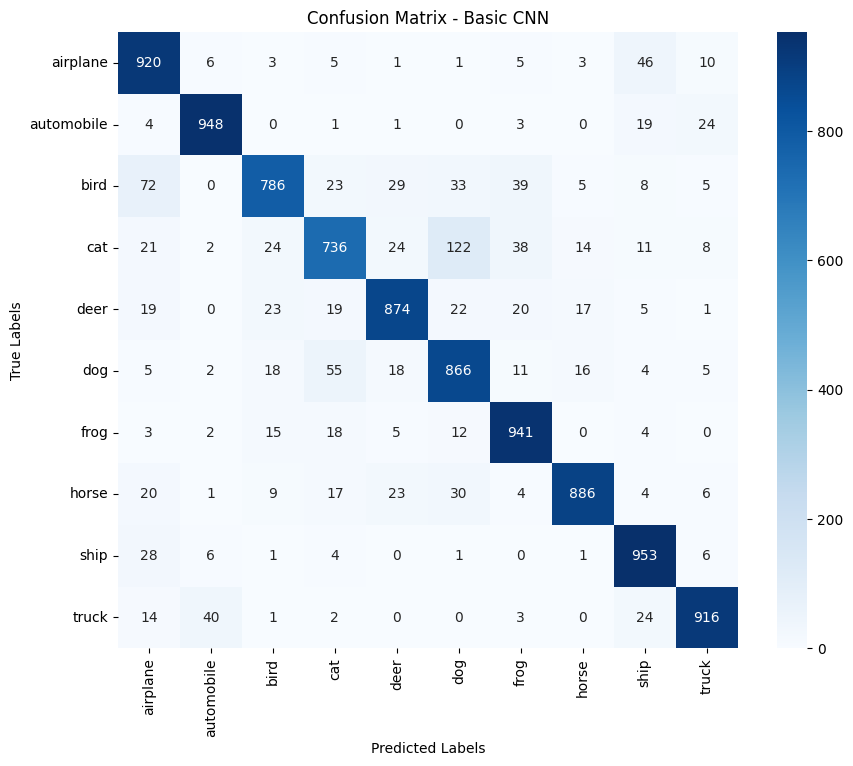

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step


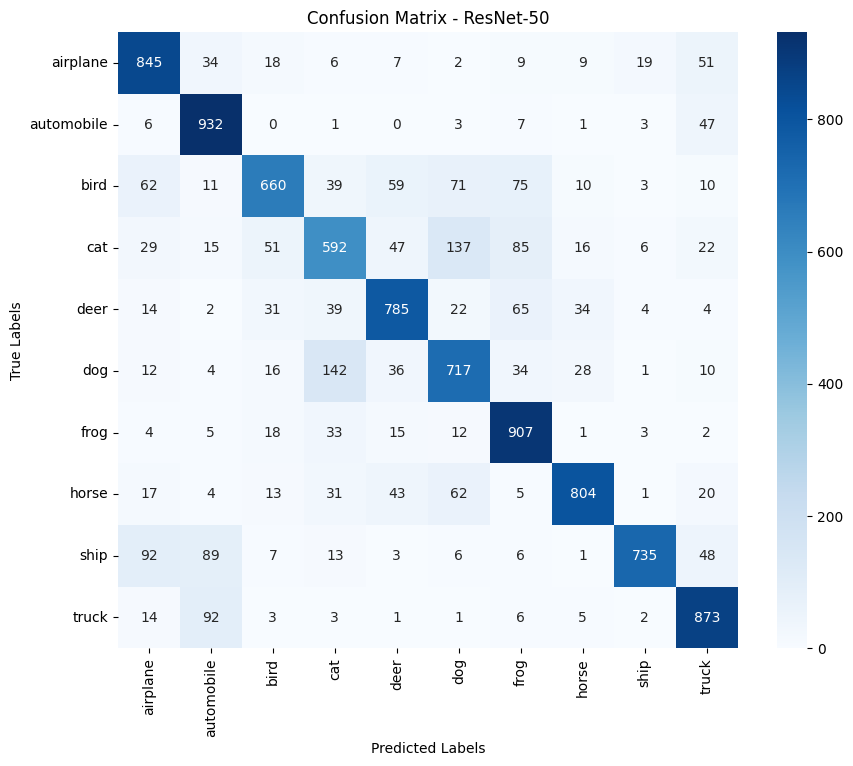

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


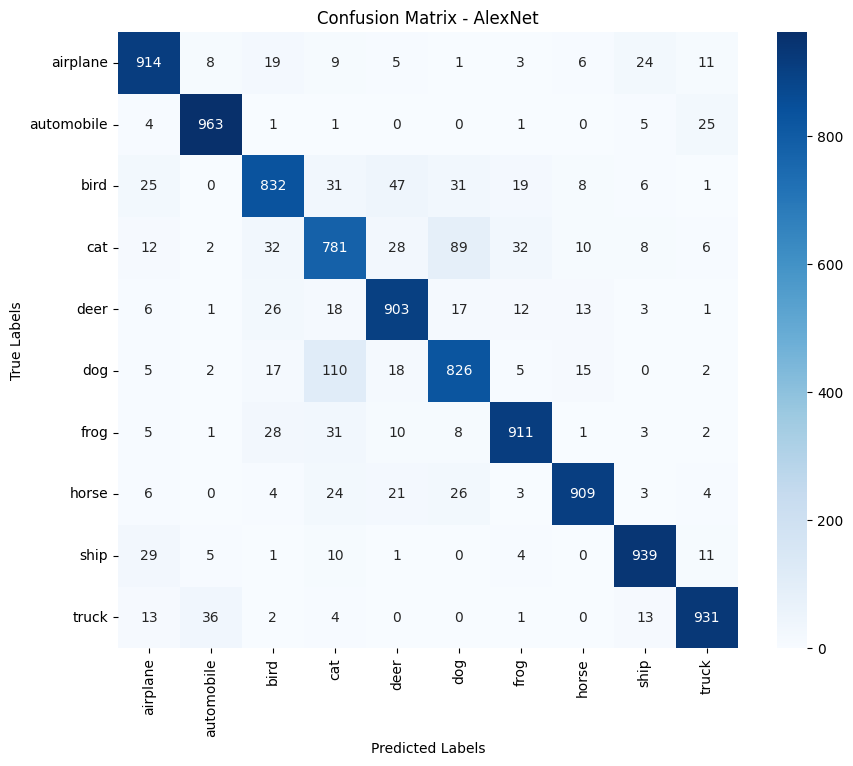

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


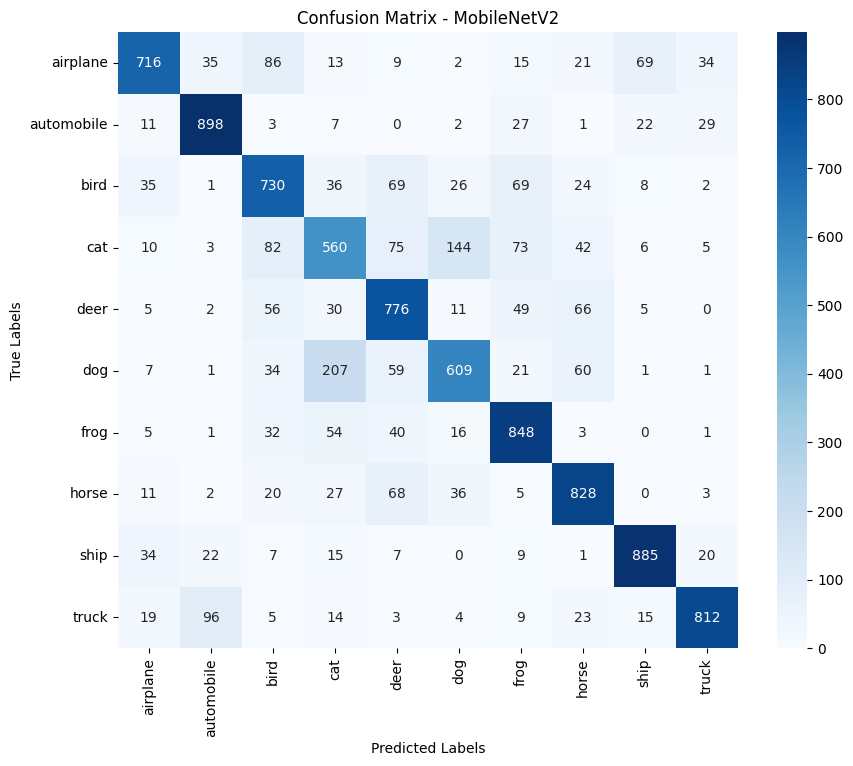

In [ ]:
plot_confusion_matrix(baseline_cnn_results[best_key_basic_cnn]['model'], baseline_cnn_results[best_key_basic_cnn]['test_generator'], 'Basic CNN', y_test)
plot_confusion_matrix(resnet_results[best_key_resnet]['model'], resnet_results[best_key_resnet]['test_generator'], 'ResNet-50', y_test)
plot_confusion_matrix(alexnet_results[best_key_alexnet]['model'], alexnet_results[best_key_alexnet]['test_generator'], 'AlexNet', y_test)
plot_confusion_matrix(mobilenetv2_results[best_key_mobilenetv2]['model'], mobilenetv2_results[best_key_mobilenetv2]['test_generator'], 'MobileNetV2', y_test)

In [ ]:
def evaluate_models_with_classification_report(models_dict, y_true, class_names):
    for model_name, result in models_dict.items():
        model = result['model']
        test_generator = result['test_generator']

        y_pred = np.argmax(model.predict(test_generator), axis=1)

        print(f"\n{'-'*50}")
        print(f"Classification Report for {model_name}")
        print(f"{'-'*50}")
        print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
models_classification_results = {
    'Basic CNN': baseline_cnn_results[best_key_basic_cnn],
    'ResNet-50': resnet_results[best_key_resnet],
    'AlexNet': alexnet_results[best_key_alexnet],
    'MobileNetV2': mobilenetv2_results[best_key_mobilenetv2]
}

In [ ]:
evaluate_models_with_classification_report(models_classification_results, y_test, class_names)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--------------------------------------------------
Classification Report for Basic CNN
--------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.83      0.92      0.87      1000
  automobile       0.94      0.95      0.94      1000
        bird       0.89      0.79      0.84      1000
         cat       0.84      0.74      0.78      1000
        deer       0.90      0.87      0.89      1000
         dog       0.80      0.87      0.83      1000
        frog       0.88      0.94      0.91      1000
       horse       0.94      0.89      0.91      1000
        ship       0.88      0.95      0.92      1000
       truck       0.93      0.92      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

---------------------